In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

ModuleNotFoundError: No module named 'pandas'

# Data Importing

In [ ]:
pumpkins = pd.read_csv('C:/Users/OITRICKENNEN/Desktop/Regression/data/US-pumpkins.csv')



pumpkins.head()


,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


# Data Cleaning

In [ ]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(pumpkins):
    # Drop columns: 'Type', 'Sub Variety', 'Grade'
    pumpkins = pumpkins.drop(columns=['Type', 'Sub Variety', 'Grade'])
    # Drop columns: 'Mostly Low', 'Mostly High' and 15 other columns
    pumpkins = pumpkins.drop(columns=['Mostly Low', 'Mostly High', 'Origin', 'Origin District', 'Item Size', 'Color', 'Environment', 'Unit of Sale', 'Quality', 'Condition', 'Appearance', 'Storage', 'Crop', 'Repack', 'Trans Mode', 'Unnamed: 24', 'Unnamed: 25'])
    # Change column type to datetime64[ns] for column: 'Date'
    pumpkins = pumpkins.astype({'Date': 'datetime64[ns]'})
    pumpkins['Month'] = pumpkins['Date'].dt.month
    pumpkins['Day'] = pumpkins['Date'].dt.day
    pumpkins['DayOfYear'] = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)
    # Filter rows based on column: 'Package'
    pumpkins = pumpkins[pumpkins['Package'].str.contains("bushel", regex=False, na=False)]
    pumpkins['Price'] = ( pumpkins['Low Price'] + pumpkins['High Price'] ) / 2
    return pumpkins

pumpkins_clean = clean_data(pumpkins.copy())
pumpkins_clean.head()

,City Name,Package,Variety,Date,Low Price,High Price,Month,Day,DayOfYear,Price
70,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,2016-09-24,15.0,15.0,9,24,267,15.0
71,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,2016-09-24,18.0,18.0,9,24,267,18.0
72,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,2016-10-01,18.0,18.0,10,1,274,18.0
73,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,2016-10-01,17.0,17.0,10,1,274,17.0
74,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,2016-10-08,15.0,15.0,10,8,281,15.0


In [ ]:
new_pumpkins = pumpkins_clean
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = new_pumpkins.Price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = new_pumpkins.Price*2
new_pumpkins = new_pumpkins.rename(columns={'City Name': 'City'})
new_pumpkins.head()

,City,Package,Variety,Date,Low Price,High Price,Month,Day,DayOfYear,Price
70,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,2016-09-24,15.0,15.0,9,24,267,13.636364
71,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,2016-09-24,18.0,18.0,9,24,267,16.363636
72,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,2016-10-01,18.0,18.0,10,1,274,16.363636
73,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,2016-10-01,17.0,17.0,10,1,274,15.454545
74,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,2016-10-08,15.0,15.0,10,8,281,13.636364


# Vizualization

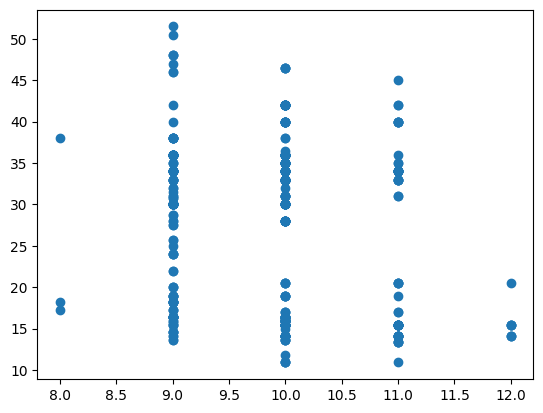

In [ ]:
# Price by Month
plt.scatter('Month','Price',data=new_pumpkins)

<Axes: xlabel='Variety'>

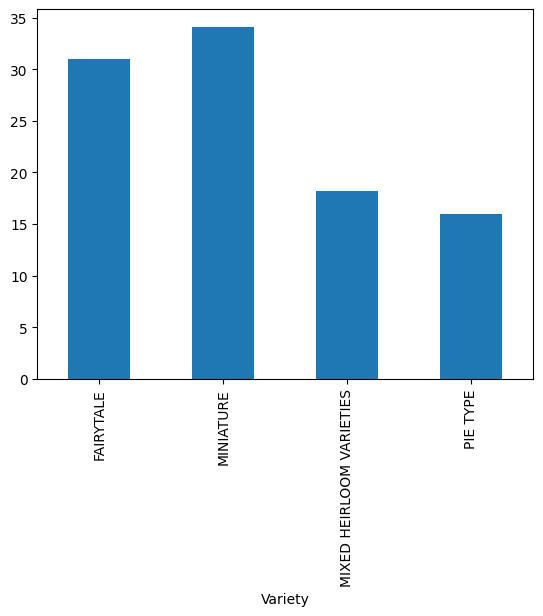

In [ ]:
# Price by Pie Type
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

# Basic Linear Regression: 

It has only one independent variable. 

- When is the best time to buy pumpkins? 
- What price can I expect of a case of miniature pumpkins?
- Should I buy them in half-bushel baskets or by the 1 1/9 bushel box?
Let's keep digging into this data.

In [ ]:
# Narrowing it down by a certain varity of pumpkin
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']

## Breakdown and Scoring

In [ ]:
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()

lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

b_0    = lin_reg.intercept_
b_1    = lin_reg.coef_[0]

print('Intercept:        {:+.5f}'.format(b_0))
print('Coefficient:      {:+.5f}'.format(b_1))

def our_predict(b_0,b_1,x):
    y = b_0 + b_1*x 
    return y


Intercept:        +21.13373
Coefficient:      -0.01752


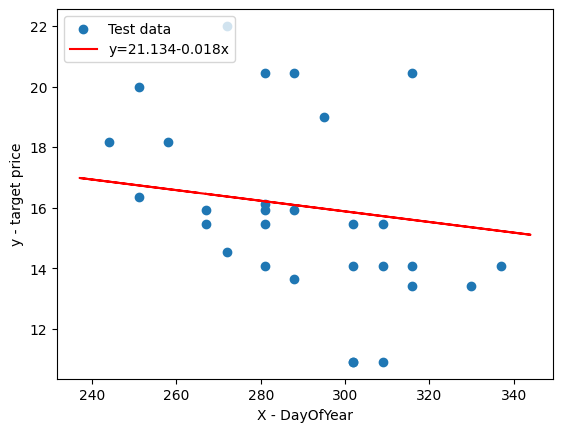

Score (Test):      0.102


In [ ]:
use_our_predict = True

# plt.scatter(X_train,y_train,label='Training data')
plt.scatter(X_test,y_test,label='Test data')
plt.xlabel("X - DayOfYear")
plt.ylabel("y - target price")
equation = "y={:.3f}{:+.3f}x".format(b_0,b_1)
if use_our_predict:
    plt.plot(X, our_predict(b_0,b_1,X), '-r', label=equation)
else:
    plt.plot(X,lin_reg.predict(X),'-r', label=equation) 
plt.legend(loc='upper left')
plt.show()

# print('Score (Training):  {:.3f}'.format(lin_reg.score(X_train, y_train)))
print('Score (Test):      {:.3f}'.format(lin_reg.score(X_test, y_test)))


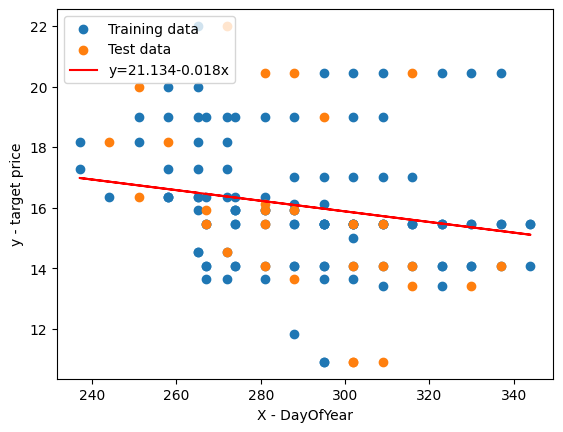

Score (Training):  0.045
Score (Test):      0.102
Mean error: 2.77 (17.2%)


In [ ]:
use_our_predict = True

plt.scatter(X_train,y_train,label='Training data')
plt.scatter(X_test,y_test,label='Test data')
plt.xlabel("X - DayOfYear")
plt.ylabel("y - target price")
equation = "y={:.3f}{:+.3f}x".format(b_0,b_1)
if use_our_predict:
    plt.plot(X, our_predict(b_0,b_1,X), '-r', label=equation)
else:
    plt.plot(X,lin_reg.predict(X),'-r', label=equation) 
plt.legend(loc='upper left')
plt.show()

print('Score (Training):  {:.3f}'.format(lin_reg.score(X_train, y_train)))
print('Score (Test):      {:.3f}'.format(lin_reg.score(X_test, y_test)))
mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')


## Prediction using unseen data

In [ ]:
# Pumpkin price on programmer's day

lin_reg.predict([[256]])

array([16.64893156])

# Multiple Linear Regression

- Multiple linear regression has multiple independent variables.

## Polynomial Regression

Sometimes the relationship between features and the results is inherently non-linear. For example, pumpkin prices might be high in winter (months=1,2), then drop over summer (months=5-7), and then rise again. Linear regression is unable to fin this relationship accurately.

In this case, we may consider adding extra features. Simple way is to use polynomials from input features, which would result in **polynomial regression**. In Scikit Learn, we can automatically pre-compute polynomial features using pipelines: 

Polynomial linear regression is a special case of multiple linear regression where the independent variables are raised to different powers.

Mean error: 2.73 (17.0%)
Model determination:  0.07639977655280172
Still not great


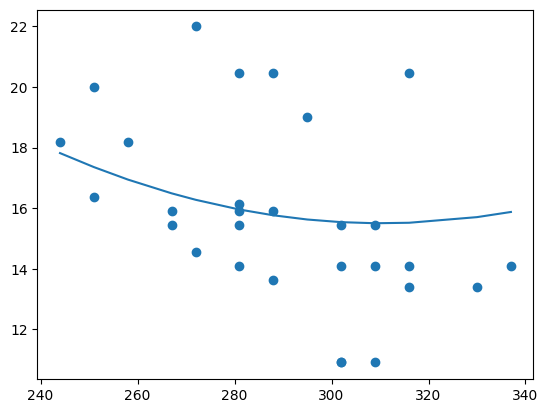

In [ ]:
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))

print("Still not great")

### Encoding varieties

In the ideal world, we want to be able to predict prices for different pumpkin varieties using the same model. To take variety into account, we first need to convert it to numeric form, or **encode**. There are several way we can do it:

* Simple numeric encoding that will build a table of different varieties, and then replace variety name by an index in that table. This is not the best idea for linear regression, because linear regression takes the numeric value of the index into account, and the numeric value is likely not to correlate numerically with the price.
* One-hot encoding, which will replace `Variety` column by 4 different columns, one for each variety, that will contain 1 if the corresponding row is of given variety, and 0 otherwise.

The code below shows how we can can one-hot encode a variety:

In [ ]:
X = pd.get_dummies(new_pumpkins['Variety'])
y = new_pumpkins['Price']

In [ ]:
def run_linear_regression(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)

    pred = lin_reg.predict(X_test)

    mse = np.sqrt(mean_squared_error(y_test,pred))
    print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

    score = lin_reg.score(X_train,y_train)
    print('Model determination: ', score)

run_linear_regression(X,y)

Mean error: 5.24 (19.7%)
Model determination:  0.774085281105197


In [ ]:
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

run_linear_regression(X,y)

### Polynomial Regression w/ Encoding

Polynomial regression can also be used with categorical features that are one-hot-encoded. The code to train polynomial regression would essentially be the same as we have seen above.

In [ ]:
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)